<a href="https://colab.research.google.com/github/zeligism/ConGAN/blob/main/ConsistentGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Header

## Imports

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import glob
import random
import datetime
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transforms
import torch.utils.tensorboard as tensorboard

from PIL import Image, ImageDraw
from math import log2
from pprint import pformat
from collections import defaultdict

## Utility Functions

### Report Utils

In [3]:
def plot_lines(losses_dict, filename=None, title=""):
    """
    Plots the losses of the discriminator and the generator.

    Args:
        filename: The plot's filename. If None, plot won't be saved.
    """

    plt.figure(figsize=(10,5))
    plt.title(title)
    for label, losses in losses_dict.items():
        plt.plot(losses, label=label)
    plt.xlabel("t")
    plt.legend()
    
    if filename is not None:
        plt.savefig(filename)
    
    plt.show()
    plt.close()


def create_progress_animation(frames, filename):
    """
    Creates a video of the progress of the generator on a fixed latent vector.

    Args:
        filename: The animation's filename.
    """

    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    ims = [[plt.imshow(img.permute(1,2,0), animated=True)]
           for img in frames]
    ani = animation.ArtistAnimation(fig, ims, blit=True)
    
    ani.save(filename)

    plt.close()


def generate_grid(generator, latent):
    """
    Check generator's output on latent vectors and return it.

    Args:
        generator: The generator.
        latent: Latent vector from which an image grid will be generated.

    Returns:
        A grid of images generated by `generator` from `latent`.
    """

    with torch.no_grad():
        fake = generator(latent).detach()

    image_grid = vutils.make_grid(fake.cpu(), padding=2, normalize=True, range=(-1,1))

    return image_grid



# Classes

## PyTorch Modules

### DCGAN

In [68]:
class ConvBlock(nn.Module):
    """
    Default stride and padding half the size of features,
    e.g. if input is [in_channels, 64, 64], output will be [out_channels, 32, 32].
    """
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1,
                 use_batchnorm=True, use_spectralnorm=False, activation=None):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding, bias=False)
        if use_spectralnorm:
            self.conv = nn.utils.spectral_norm(self.conv)
        self.batchnorm = nn.BatchNorm2d(out_channels) if use_batchnorm else None
        self.activation = nn.LeakyReLU(0.2, inplace=True) if activation is None else activation()

    def forward(self, x):
        x = self.conv(x)
        if self.batchnorm:
            x = self.batchnorm(x)
        x = self.activation(x)
        return x


class ConvTBlock(nn.Module):
    """
    Default stride and padding double the size of features,
    e.g. if input is [in_channels, 32, 32], output will be [out_channels, 64, 64].
    """
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1,
                 use_batchnorm=True, use_spectralnorm=False, activation=None):
        super().__init__()

        self.convT = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size,
                                        stride=stride, padding=padding, bias=False)
        if use_spectralnorm:
            self.convT = nn.utils.spectral_norm(self.convT)
        self.batchnorm = nn.BatchNorm2d(out_channels) if use_batchnorm else None
        self.activation = nn.ReLU(inplace=True) if activation is None else activation()

    def forward(self, x):
        x = self.convT(x)
        if self.batchnorm:
            x = self.batchnorm(x)
        x = self.activation(x)
        return x


class DCGAN_Discriminator(nn.Module):
    def __init__(self,
                 num_latents=16,
                 num_features=64,
                 image_channels=3,
                 image_size=64,
                 feature_multiplier=2,
                 max_features=512,
                 gan_type="gan",
                 fully_convolutional=True,
                 activation=None,
                 use_batchnorm=True,
                 use_spectralnorm=False,
                 D_block=ConvBlock):
        super().__init__()

        using_grad_penalty = gan_type in ("gan-gp", "wgan-gp")
        output_sigmoid = gan_type in ("gan", "gan-gp")

        block_config = {
            "activation": activation,
            "use_batchnorm": use_batchnorm and not using_grad_penalty,
            "use_spectralnorm": use_spectralnorm,
        }

        # Calculate intermediate image sizes
        image_sizes = [image_size]
        while image_sizes[-1] > 5:
            image_sizes.append(image_sizes[-1] // 2)
        latent_kernel = image_sizes[-1]  # should be either 3, 4, or 5
        num_layers = len(image_sizes) - 1

        # Calculate feature sizes
        features = [min(max_features, round(num_features * feature_multiplier**i))
                    for i in range(num_layers)]

        # Input layer
        self.input_layer = D_block(image_channels, features[0], **block_config)

        # Intermediate layers
        self.main_layers = nn.Sequential(*[
            D_block(in_features, out_features, **block_config)
            for in_features, out_features in zip(features, features[1:])
        ])

        # Output layer (feature_size = 3, 4, or 5 -> 1)
        if fully_convolutional:
            self.output_layer = nn.Sequential(
                nn.Conv2d(features[-1], num_latents, latent_kernel, bias=False),
                nn.Flatten(),
            )
        else:
            self.output_layer = nn.Sequential(
                nn.Flatten(),
                nn.Linear(features[-1] * latent_kernel**2, num_latents, bias=False)
            )

        # Add sigmoid activation if using regular GAN loss
        self.output_activation = nn.Sigmoid() if output_sigmoid else None

    def forward(self, x):
        x = self.input_layer(x)
        x = self.main_layers(x)
        x = self.output_layer(x)
        if self.output_activation:
            x = self.output_activation(x)
        # Remove H and W dimensions, infer channels dim (remove if 1)
        x = x.view(x.size(0), -1).squeeze(1)
        return x


class DCGAN_Generator(nn.Module):
    def __init__(self,
                 num_latents=100,
                 num_features=64,
                 image_channels=3,
                 image_size=64,
                 feature_multiplier=2,
                 max_features=512,
                 gan_type="gan",
                 fully_convolutional=True,
                 activation=None,
                 use_batchnorm=True,
                 use_spectralnorm=False,
                 G_block=ConvTBlock):
        super().__init__()

        block_config = {
            "activation": activation,
            "use_batchnorm": use_batchnorm,
            "use_spectralnorm": use_spectralnorm
        }

        # Calculate intermediate image sizes
        image_sizes = [image_size]
        while image_sizes[-1] > 5:
            image_sizes.append(image_sizes[-1] // 2)
        latent_kernel = image_sizes[-1]  # should be either 3, 4, or 5
        num_layers = len(image_sizes) - 1

        # Calculate feature sizes
        features = [min(max_features, round(num_features * feature_multiplier**i))
                    for i in range(num_layers)]

        # Reverse order of image sizes and features for generator
        image_sizes = image_sizes[::-1]
        features = features[::-1]

        # Input layer
        if fully_convolutional:
            self.input_layer = G_block(num_latents, features[0], kernel_size=latent_kernel,
                                       stride=1, padding=0, **block_config)
        else:
            self.input_layer = nn.Sequential(
                nn.Flatten(),
                nn.Linear(num_latents, features[0] * image_sizes[0]**2, bias=False),
                View(features[0], image_sizes[0], image_sizes[0])
            )

        # Intermediate layers
        self.main_layers = nn.Sequential(*[
            G_block(in_features, out_features, kernel_size=4+(expected_size%2), **block_config)
            for in_features, out_features, expected_size in zip(features, features[1:], image_sizes[1:])
        ])

        # Output layer
        self.output_layer = nn.ConvTranspose2d(features[-1], image_channels, kernel_size=4+(image_size%2),
                                               stride=2, padding=1, bias=False)
        self.output_activation = nn.Tanh()

    def forward(self, x):
        # Add H and W dimensions, infer channels dim (add if none)
        x = x.view(x.size(0), -1, 1, 1)
        x = self.input_layer(x)
        x = self.main_layers(x)
        x = self.output_layer(x)
        x = self.output_activation(x)
        return x


class DCGAN(nn.Module):
    """Deep Convolutional Generative Adversarial Network"""

    def __init__(self,
                 num_latents=100,
                 num_features=64,
                 image_channels=3,
                 image_size=64,
                 feature_multiplier=2,
                 gan_type="gan",
                 fully_convolutional=True,
                 activation=None,
                 use_batchnorm=True,
                 use_spectralnorm=False,):
        """
        Initializes DCGAN.

        Args:
            num_latents: Number of latent factors.
            num_features: Number of features in the convolutions.
            image_channels: Number of channels in the input image.
            image_size: Size (i.e. height or width) of image.
            gan_type: Type of GAN (e.g. "gan" or "wgan-gp").
        """
        super().__init__()

        self.num_latents = num_latents
        self.num_features = num_features
        self.image_channels = image_channels
        self.image_size = image_size
        self.feature_multiplier = feature_multiplier
        self.gan_type = gan_type
        self.fully_convolutional = fully_convolutional
        self.activation = activation
        self.use_batchnorm = use_batchnorm
        self.use_spectralnorm = use_spectralnorm

        D_params = {
            "num_latents": 1,  # XXX
            "num_features": num_features,
            "image_channels": image_channels,
            "image_size": image_size,
            "feature_multiplier": feature_multiplier,
            "gan_type": gan_type,
            "fully_convolutional": fully_convolutional,
            "activation": activation,
            "use_batchnorm": use_batchnorm,
            "use_spectralnorm": use_spectralnorm,
        }
        G_params = {
            "num_latents": num_latents,
            "num_features": num_features,
            "image_channels": image_channels,
            "image_size": image_size,
            "feature_multiplier": feature_multiplier,
            "gan_type": gan_type,
            "fully_convolutional": fully_convolutional,
            "activation": activation,
            "use_batchnorm": use_batchnorm,
            "use_spectralnorm": use_spectralnorm,
        }

        self.D = DCGAN_Discriminator(**D_params)
        self.G = DCGAN_Generator(**G_params)


class View(nn.Module):
    def __init__(self, *shape, including_batch=False):
        super().__init__()
        self.shape = shape
        self.including_batch = including_batch
    
    def forward(self, x):
        if self.including_batch:
            return x.view(*self.shape)
        else:
            return x.view(x.size(0), *self.shape)

class ChannelNoise(nn.Module):
    """
    Channel noise injection module.
    Adds a linearly transformed noise to a convolution layer.
    """

    def __init__(self, num_channels, std=0.02):
        super().__init__()
        self.std = std
        self.scale = nn.Parameter(torch.ones(1, num_channels, 1, 1))


    def forward(self, x):
        noise_size = [x.size()[0], 1, *x.size()[2:]]  # single channel
        noise = self.std * torch.randn(noise_size).to(x)

        return x + self.scale * noise

### SimSiam

In [69]:
class SimSiam(nn.Module):
    """
    Build a SimSiam model.
    """
    def __init__(self, base_encoder, dim=2048, pred_dim=512):
        """
        dim: feature dimension (default: 2048)
        pred_dim: hidden dimension of the predictor (default: 512)
        """
        super(SimSiam, self).__init__()

        # create the encoder
        # num_classes is the output fc dimension, zero-initialize last BNs
        self.encoder = base_encoder(num_classes=dim, zero_init_residual=True)

        # build a 3-layer projector
        prev_dim = self.encoder.fc.weight.shape[1]
        self.encoder.fc = nn.Sequential(nn.Linear(prev_dim, prev_dim, bias=False),
                                        nn.BatchNorm1d(prev_dim),
                                        nn.ReLU(inplace=True), # first layer
                                        nn.Linear(prev_dim, prev_dim, bias=False),
                                        nn.BatchNorm1d(prev_dim),
                                        nn.ReLU(inplace=True), # second layer
                                        self.encoder.fc,
                                        nn.BatchNorm1d(dim, affine=False)) # output layer
        self.encoder.fc[6].bias.requires_grad = False # hack: not use bias as it is followed by BN

        # build a 2-layer predictor
        self.predictor = nn.Sequential(nn.Linear(dim, pred_dim, bias=False),
                                        nn.BatchNorm1d(pred_dim),
                                        nn.ReLU(inplace=True), # hidden layer
                                        nn.Linear(pred_dim, dim)) # output layer

    def forward(self, x1, x2):
        """
        Input:
            x1: first views of images
            x2: second views of images
        Output:
            p1, p2, z1, z2: predictors and targets of the network
            See Sec. 3 of https://arxiv.org/abs/2011.10566 for detailed notations
        """

        # compute features for one view
        z1 = self.encoder(x1) # NxC
        z2 = self.encoder(x2) # NxC

        p1 = self.predictor(z1) # NxC
        p2 = self.predictor(z2) # NxC

        return p1, p2, z1.detach(), z2.detach()

### ConsistentGAN

In [71]:
class ConsistentGAN(nn.Module):
    def __init__(self, repr_dim, latent_dim,
                 D_batchnorm=True, image_size=64, *args, **kwargs):
        super().__init__()
        self.repr_dim = repr_dim
        self.latent_dim = latent_dim
        
        # Make D's architecture kinda similar to predictor
        D_hidden_dim = repr_dim // 10
        if D_batchnorm:
            self.D = nn.Sequential(nn.Linear(repr_dim, D_hidden_dim, bias=False),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Linear(D_hidden_dim, D_hidden_dim, bias=False),
                                   nn.BatchNorm1d(D_hidden_dim),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Linear(D_hidden_dim, 1),
                                   nn.Sigmoid())
        else:
            self.D = nn.Sequential(nn.Linear(repr_dim, D_hidden_dim, bias=False),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Linear(D_hidden_dim, D_hidden_dim, bias=False),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Linear(D_hidden_dim, 1),
                                   nn.Sigmoid())


        # Same for generator (latent -> representations)
        G_hidden_dim = repr_dim // 10
        self.G = nn.Sequential(nn.Linear(latent_dim, G_hidden_dim, bias=False),
                               nn.BatchNorm1d(G_hidden_dim),
                               nn.LeakyReLU(0.2, inplace=True),
                               nn.Linear(G_hidden_dim, G_hidden_dim, bias=False),
                               nn.BatchNorm1d(G_hidden_dim),
                               nn.LeakyReLU(0.2, inplace=True),
                               nn.Linear(G_hidden_dim, G_hidden_dim, bias=False),
                               nn.BatchNorm1d(G_hidden_dim),
                               nn.LeakyReLU(0.2, inplace=True),
                               nn.Linear(G_hidden_dim, G_hidden_dim, bias=False),
                               nn.BatchNorm1d(G_hidden_dim),
                               nn.LeakyReLU(0.2, inplace=True),
                               nn.Linear(G_hidden_dim, G_hidden_dim, bias=False),
                               nn.BatchNorm1d(G_hidden_dim),
                               nn.LeakyReLU(0.2, inplace=True),
                               nn.Linear(G_hidden_dim, G_hidden_dim, bias=False),
                               nn.BatchNorm1d(G_hidden_dim),
                               nn.LeakyReLU(0.2, inplace=True),
                               nn.Linear(G_hidden_dim, repr_dim, bias=False),
                               nn.BatchNorm1d(repr_dim, affine=False),
                               Normalize2()
                               )

        # Encodes x to context @XXX
        ctx_dim = 256
        self.ctx_encoder = DCGAN_Discriminator(num_latents=ctx_dim, image_size=image_size)

        # Projections to decoding space
        # Decodes representation + context projection to an image
        num_latents = 512
        self.repr_proj = nn.Sequential(nn.Linear(repr_dim, num_latents // 2), nn.Sigmoid())
        self.ctx_proj = nn.Sequential(nn.Linear(ctx_dim, num_latents // 2), nn.Sigmoid())
        self.decoder = DCGAN_Generator(num_latents=num_latents, image_size=image_size)

        # To check progress of G
        self.fixed_latent = self.sample_latent(8*8)
    
    # XXX temp function
    def proj(self, repr, ctx, return_all=False):
        repr_proj = self.repr_proj(repr)
        ctx_proj = self.ctx_proj(ctx)
        proj = torch.cat([repr_proj, ctx_proj], dim=1)
        if return_all:
            return proj, repr_proj, ctx_proj
        else:
            return proj

    def sample_latent(self, batch_size):
        latent_size = [batch_size, self.latent_dim]
        latent = torch.randn(latent_size)
        return latent


class Normalize2(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return F.normalize(x, p=2, dim=1)


# Training v2

### Imports and globals

In [72]:
import argparse
import builtins
import math
import os
import random
import shutil
import time
import warnings
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

GANSIAM_DIR = "/content/drive/My Drive/gansiam/"
SIMSIAM_PATH = os.path.join(GANSIAM_DIR, "pretrained_batch256.tar")
TINYIMAGENET_DIR = "tiny-imagenet-200"

### Download Tiny Imagenet

In [8]:
%%bash
if [[ -d  "tiny-imagenet-200" ]]; then
    echo "Tiny Imagenet exists."
else
    wget -q "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    unzip -qq "tiny-imagenet-200.zip" && rm "tiny-imagenet-200.zip"
    echo "Downloaded Tiny Imagenet."
fi

Downloaded Tiny Imagenet.


### Utility

#### GAN Utils

In [9]:
def get_D_loss(gan_type="gan"):
    if gan_type in ("gan", "gan-gp"):
        return D_loss_GAN
    elif gan_type in ("wgan", "wgan-gp"):
        return D_loss_WGAN
    else:
        raise ValueError(f"gan_type {gan_type} not supported")


def get_G_loss(gan_type="gan"):
    if gan_type in ("gan", "gan-gp"):
        return G_loss_GAN
    elif gan_type in ("wgan", "wgan-gp"):
        return G_loss_WGAN
    else:
        raise ValueError(f"gan_type {gan_type} not supported")


def D_loss_GAN(D_real, D_fake, label_smoothing=True):
    
    # Create (noisy) real and fake labels XXX
    if label_smoothing:
        real_label = 0.7 + 0.5 * torch.rand_like(D_real)
    else:
        real_label = torch.ones_like(D_real) - 0.1
    fake_label = torch.zeros_like(D_fake)

    # Calculate binary cross entropy loss
    D_loss_real = F.binary_cross_entropy(D_real, real_label)
    D_loss_fake = F.binary_cross_entropy(D_fake, fake_label)

    # Loss is: - log(D(x)) - log(1 - D(x_g)),
    # which is equiv. to maximizing: log(D(x)) + log(1 - D(x_g))
    D_loss = D_loss_real + D_loss_fake

    return D_loss.mean()


def D_loss_WGAN(D_real, D_fake):

    # Maximize: D(x) - D(x_g) - const * (|| grad of D(x_i) wrt x_i || - 1)^2,
    # where x_i <- eps * x + (1 - eps) * x_g, and eps ~ rand(0,1)
    D_loss = -1 * (D_real - D_fake)

    return D_loss.mean()


def G_loss_GAN(D_fake):

    # Calculate binary cross entropy loss with a fake binary label
    fake_label = torch.zeros_like(D_fake)

    # Loss is: -log(D(G(z))), which is equiv. to minimizing log(1-D(G(z)))
    # We use this loss vs. the original one for stability only.
    G_loss = F.binary_cross_entropy(D_fake, 1 - fake_label)

    return G_loss.mean()


def G_loss_WGAN(D_fake):

    # Minimize: -D(G(z))
    G_loss = -D_fake
    
    return G_loss.mean()


def interpolate(real, fake):
    eps_size = [1] * len(real.size())
    eps_size[0] = real.size(0)
    eps = torch.rand(eps_size).to(real)
    return eps * real + (1 - eps) * fake

def simple_gradient_penalty(D, x, center=0.):
    x.requires_grad_()
    D_x = D(x)
    D_grad = torch.autograd.grad(D_x, x, torch.ones_like(D_x), create_graph=True)
    D_grad_norm = D_grad[0].view(x.size(0), -1).norm(dim=1)
    return (D_grad_norm - center).pow(2).mean()


#### Data Utils

In [10]:
from PIL import ImageFilter
import random


class TwoCropsTransform:
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return [q, k]


class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x

#### Train Utils

In [11]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    filename = os.path.join(GANSIAM_DIR, "results", filename)
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


def adjust_learning_rate(optimizer, init_lr, epoch, args):
    """Decay the learning rate based on schedule"""
    cur_lr = init_lr * 0.5 * (1. + math.cos(math.pi * epoch / args.epochs))
    for param_group in optimizer.param_groups:
        if 'fix_lr' in param_group and param_group['fix_lr']:
            param_group['lr'] = init_lr
        else:
            param_group['lr'] = cur_lr


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


### Load pre-trained SimSiam model


In [12]:
checkpoint = torch.load(SIMSIAM_PATH, map_location="cuda:0")
# remove 'module.' from dict keys
model_dict = OrderedDict((k[7:], v) for k, v in checkpoint["state_dict"].items())

# Load model
simsiam = SimSiam(models.__dict__["resnet50"])
simsiam.load_state_dict(model_dict)
#print(simsiam)

<All keys matched successfully>

### Declare arguments

In [90]:
class Args:
    def __init__(self):
        self.data = TINYIMAGENET_DIR
        self.workers = 2
        self.epochs = 25
        self.batch_size = 256
        self.D_lr = 1e-4
        self.G_lr = 2e-4
        self.decoder_lr = 1e-4
        self.momentum = 0.9
        self.weight_decay = 1e-4
        self.print_freq = 10
        self.seed = None
        self.gpu = 0

        # SimSiam (don't change if loading pre-trained)
        self.dim = 2048
        self.pred_dim = 512

        # GAN
        self.gan_type = "gan-gp"
        self.repr_dim = self.dim  # don't change
        self.latent_dim = 256
        self.D_iters = 3
        self.noise = 1e-6
        self.grad_penalty = 10.
        self.grad_center = 1.
        self.generate_grid_interval = 50

        self.rec_penalty = 0.01
        self.repr_consistency = 10.
        self.norm_penalty = 1.
        self.div_penalty = 1.

GENERATED_GRIDS = []
IMAGE_SIZE = 64
args = Args()

### Data loading and transformation

In [91]:
# image normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=mean, std=std)
inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)


# MoCo v2's aug: similar to SimCLR https://arxiv.org/abs/2002.05709
"""
augmentation = [
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.2, 1.)),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
]
"""


augmentation = [
    #transforms.RandomResizedCrop(IMAGE_SIZE),
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
]

DATASET = "CIFAR10"

if DATASET == "MNIST":
    augmentation = [transforms.Grayscale(3)] + augmentation
    train_dataset = datasets.MNIST(
        root=os.path.join(GANSIAM_DIR, "mnist/train"), train=True, download=True,
        transform=transforms.Compose(augmentation))
elif DATASET == "CelebA":
    train_dataset = datasets.CelebA(
        root=os.path.join(GANSIAM_DIR, "celeba"), download=True,
        transform=transforms.Compose(augmentation))
elif DATASET == "CIFAR10":
    train_dataset = datasets.CIFAR10(
        root=os.path.join(GANSIAM_DIR, "cifar10/train"), train=True, download=True,
        transform=transforms.Compose(augmentation))
        #transform=TwoCropsTransform(transforms.Compose(augmentation)))
elif DATASET == "Tiny Imagenet":
    train_dataset = datasets.ImageFolder(
        root=os.path.join(TINYIMAGENET_DIR, 'train'),
        transform=transforms.Compose(augmentation))
else:
    raise Exception(f"Dataset '{DATASET}' not found")

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=args.batch_size, shuffle=True,
    num_workers=args.workers, pin_memory=True, sampler=None, drop_last=True)

Files already downloaded and verified


### Init model and optimizers

In [92]:
if args.seed is not None:
    random.seed(args.seed)
    torch.manual_seed(args.seed)
    cudnn.deterministic = True

torch.cuda.set_device(args.gpu)

model = ConsistentGAN(args.repr_dim, args.latent_dim,
                      D_batchnorm=args.gan_type in ("gan", "wgan"),
                      image_size=IMAGE_SIZE)
model = model.cuda(args.gpu)
simsiam = simsiam.cuda(args.gpu)
#print(model)

# Define D and G loss functions
D_criterion = get_D_loss(args.gan_type)
G_criterion = get_G_loss(args.gan_type)
def rec_criterion(x, y):
    return (x - y).pow(2).flatten(start_dim=1).sum(dim=1).mean()

D_optimizer = torch.optim.Adam(
    model.D.parameters(), args.D_lr)
G_optimizer = torch.optim.Adam(
    model.G.parameters(), args.G_lr)

encoder_lr = args.decoder_lr
proj_lr = args.decoder_lr
ae_params = [{'params': model.decoder.parameters()},
             {'params': model.ctx_encoder.parameters(), 'lr': encoder_lr},
             {'params': model.repr_proj.parameters(), 'lr': proj_lr},
             {'params': model.ctx_proj.parameters(), 'lr': proj_lr},]
ae_optimizer = torch.optim.Adam(ae_params, args.decoder_lr)

cudnn.benchmark = True

print("Num of params:", sum(map(torch.numel, model.parameters())))

Num of params: 13536957


### Training

In [93]:
def train(train_loader, model, simsiam,
          rec_criterion, D_criterion, G_criterion,
          D_optimizer, G_optimizer, ae_optimizer,
          epoch, args):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    D_on_reals = AverageMeter('D(real)', ':.4f')
    D_on_fakes = AverageMeter('D(fake)', ':.4f')
    D_grads = AverageMeter('grad(D) penalty', ':.4f')
    rec_losses = AverageMeter('Rec loss', ':.4f')
    norms = AverageMeter('norm', ':.4f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time,
         D_on_reals, D_on_fakes, D_grads, rec_losses, norms],
        prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    model.train()

    end = time.time()
    for i, (x, y) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        x = x.cuda(args.gpu, non_blocking=True)
        batch_size = x.size(0)

        # compute output and loss
        with torch.no_grad():
            repr = simsiam.encoder(x)
            repr = F.normalize(repr, p=2, dim=1)

        ### train GAN
        if (i+1) % (args.D_iters+1) > 0:
            latent = model.sample_latent(batch_size).cuda(args.gpu)
            
            # Add noise to real sample
            real = repr + args.noise * torch.randn_like(repr)

            # Sample from generator
            with torch.no_grad():
                fake = model.G(latent)
                # Add noise to fake sample as well
                fake += torch.randn_like(fake) * args.noise

            # Classify real and fake data
            D_real = model.D(real)
            D_fake = model.D(fake)

            # Calculate loss
            D_loss = D_criterion(D_real, D_fake)
            # Gradient penalty
            D_grad_penalty = simple_gradient_penalty(
                model.D, interpolate(real, fake), center=args.grad_center)
            D_loss += args.grad_penalty * D_grad_penalty

            # Calculate gradient and minimize
            D_optimizer.zero_grad()
            D_loss.backward()
            D_optimizer.step()

        else:
            # Sample from generators
            latent = model.sample_latent(batch_size).cuda(args.gpu)
            fake = model.G(latent)
            fake += args.noise * torch.randn_like(fake)
            # Classify fake images
            D_fake = model.D(fake)
            # Calculate loss
            G_loss = G_criterion(D_fake)
            # Calculate gradient and minimize
            G_optimizer.zero_grad()
            G_loss.backward()
            G_optimizer.step()

            # Save D's evaluations on real and fake
            D_on_reals.update(D_real.mean().item(), batch_size)
            D_on_fakes.update(D_fake.mean().item(), batch_size)
            D_grads.update(D_grad_penalty.mean().item(), batch_size)

        # Calculate Reconstruction loss
        ctx = model.ctx_encoder(x)
        proj, repr_proj, ctx_proj = model.proj(repr, ctx, return_all=True)
        x_rec = model.decoder(proj + 1e-4 * torch.randn_like(proj))
        # loss
        rec_loss = args.rec_penalty * rec_criterion(x, x_rec)
        enc_norm = proj.flatten(start_dim=1).norm(dim=1).mean()
        rec_loss += args.norm_penalty * enc_norm
        with torch.no_grad():
            repr_rec = simsiam.encoder(x_rec)
            repr_rec = F.normalize(repr_rec, p=2, dim=1)
        rec_loss += args.repr_consistency * rec_criterion(repr, repr_rec)
        # increase divergence between repr and ctx projections
        rec_loss += -1 * args.div_penalty * F.kl_div(repr_proj, ctx_proj, reduction='batchmean')
        
        ae_optimizer.zero_grad()
        rec_loss.backward()
        ae_optimizer.step()

        rec_losses.update(rec_loss.item(), batch_size)
        norms.update(enc_norm.item(), batch_size)

        # Check generator's progress by recording its output on a fixed input
        if i % args.generate_grid_interval == 0:
            def decode_latent(z):
                repr = model.G(z)
                ctx = model.ctx_encoder(x[:model.fixed_latent.size(0)])  # ref x
                proj = model.proj(repr, ctx)
                return model.decoder(proj)

            grid = generate_grid(decode_latent, model.fixed_latent.cuda(args.gpu))
            GENERATED_GRIDS.append(grid)

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            progress.display(i)


In [94]:
for epoch in range(args.epochs):
    # train for one epoch
    train(train_loader, model, simsiam,
          rec_criterion, D_criterion, G_criterion,
          D_optimizer, G_optimizer, ae_optimizer,
          epoch, args)

    if epoch % 10 == 0:
        save_checkpoint({
            'state_dict': model.state_dict(),
        }, is_best=False, filename='checkpoint_{:04d}.pth.tar'.format(epoch))

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


Epoch: [0][  0/195]	Time  0.653 ( 0.653)	Data  0.317 ( 0.317)	D(real) 0.0000 (0.0000)	D(fake) 0.0000 (0.0000)	grad(D) penalty 0.0000 (0.0000)	Rec loss 380.2957 (380.2957)	norm 11.2696 (11.2696)
Epoch: [0][ 10/195]	Time  0.234 ( 0.276)	Data  0.000 ( 0.029)	D(real) 0.5114 (0.5113)	D(fake) 0.5111 (0.5110)	grad(D) penalty 0.9379 (0.9433)	Rec loss 341.4819 (345.2569)	norm 10.5745 (10.8750)
Epoch: [0][ 20/195]	Time  0.238 ( 0.257)	Data  0.000 ( 0.015)	D(real) 0.5114 (0.5114)	D(fake) 0.5112 (0.5111)	grad(D) penalty 0.8935 (0.9235)	Rec loss 316.2151 (335.0935)	norm 10.1770 (10.6252)
Epoch: [0][ 30/195]	Time  0.236 ( 0.250)	Data  0.000 ( 0.011)	D(real) 0.5119 (0.5115)	D(fake) 0.5114 (0.5112)	grad(D) penalty 0.8511 (0.9061)	Rec loss 307.4454 (326.9164)	norm 9.7931 (10.4133)
Epoch: [0][ 40/195]	Time  0.231 ( 0.246)	Data  0.000 ( 0.008)	D(real) 0.5115 (0.5116)	D(fake) 0.5120 (0.5114)	grad(D) penalty 0.7617 (0.8728)	Rec loss 301.8481 (320.5195)	norm 9.4395 (10.2177)
Epoch: [0][ 50/195]	Time  0.257 

### Check results

In [95]:
vidname = os.path.join(GANSIAM_DIR, "results/test.mp4")
create_progress_animation(GENERATED_GRIDS, vidname)

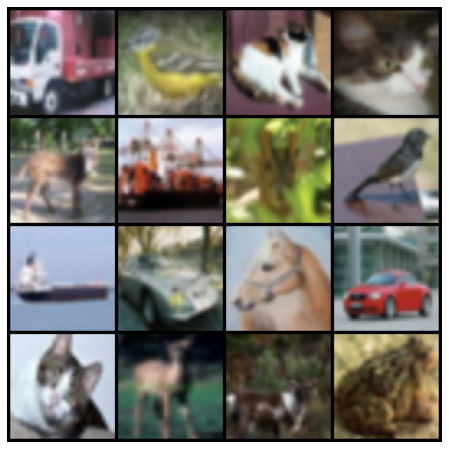

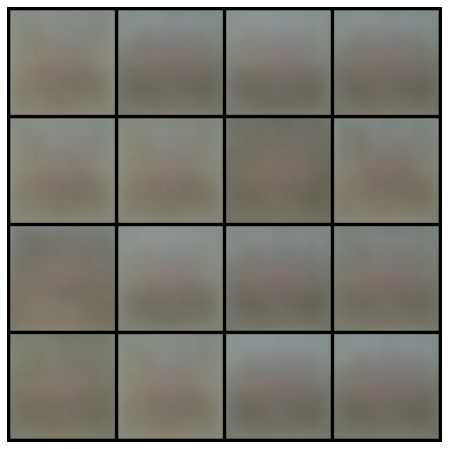

In [96]:
%matplotlib inline

def show_sample(x, num_samples=16, show_x=False):
    x = x.cuda(args.gpu)[:num_samples]
    if show_x:
        x_grid = vutils.make_grid(inv_normalize(x).cpu(), padding=2, nrow=4)
        plt.figure(figsize=(8,8))
        plt.axis("off")
        plt.imshow(x_grid.permute(1,2,0))

    model.eval()
    with torch.no_grad():
        z = model.sample_latent(num_samples).cuda(args.gpu)
        im_tensor = model.decoder(model.proj(model.G(z), model.ctx_encoder(x)))
    im_grid = vutils.make_grid(inv_normalize(im_tensor).cpu(), padding=2, nrow=4)
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.imshow(im_grid.permute(1,2,0))

x, _ = next(iter(train_loader))
show_sample(x, show_x=True)

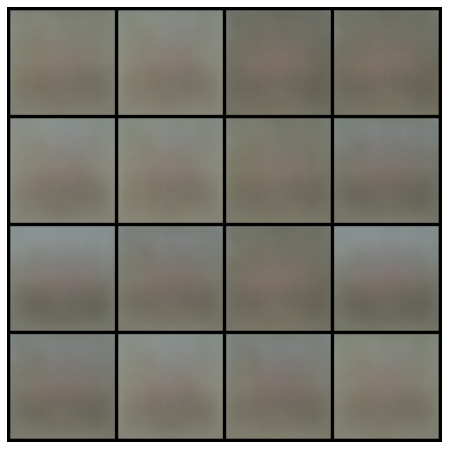

In [97]:
show_sample(x)

# Training v3

## Args

In [155]:
class Args:
    def __init__(self):
        self.data = TINYIMAGENET_DIR
        self.workers = 2
        self.epochs = 250
        self.batch_size = 256
        self.D_lr = 4e-4
        self.G_lr = 2e-4
        self.momentum = 0.9
        self.weight_decay = 1e-4
        self.print_freq = 10
        self.seed = None
        self.gpu = 0

        # SimSiam (don't change if loading pre-trained)
        self.dim = 2048
        self.pred_dim = 512

        # GAN
        self.gan_type = "wgan-gp"
        self.repr_dim = self.dim  # don't change
        self.latent_dim = 256
        self.D_iters = 3
        self.noise = 1e-3
        self.grad_penalty = 10.
        self.grad_center = 1.
        self.generate_grid_interval = 100

        # Repr
        self.repr_consistency = 1.


GENERATED_GRIDS = []
IMAGE_SIZE = 64
args = Args()

## Data

In [156]:
# image normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=mean, std=std)
inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)


# MoCo v2's aug: similar to SimCLR https://arxiv.org/abs/2002.05709
"""
augmentation = [
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.2, 1.)),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
]
"""


augmentation = [
    #transforms.RandomResizedCrop(IMAGE_SIZE),
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
]

DATASET = "CIFAR10"

if DATASET == "MNIST":
    augmentation = [transforms.Grayscale(3)] + augmentation
    train_dataset = datasets.MNIST(
        root=os.path.join(GANSIAM_DIR, "mnist/train"), train=True, download=True,
        transform=transforms.Compose(augmentation))
elif DATASET == "CelebA":
    train_dataset = datasets.CelebA(
        root=os.path.join(GANSIAM_DIR, "celeba"), download=True,
        transform=transforms.Compose(augmentation))
elif DATASET == "CIFAR10":
    train_dataset = datasets.CIFAR10(
        root=os.path.join(GANSIAM_DIR, "cifar10/train"), train=True, download=True,
        transform=transforms.Compose(augmentation))
        #transform=TwoCropsTransform(transforms.Compose(augmentation)))
elif DATASET == "Tiny Imagenet":
    train_dataset = datasets.ImageFolder(
        root=os.path.join(TINYIMAGENET_DIR, 'train'),
        transform=transforms.Compose(augmentation))
else:
    raise Exception(f"Dataset '{DATASET}' not found")

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=args.batch_size, shuffle=True,
    num_workers=args.workers, pin_memory=True, sampler=None, drop_last=True)

Files already downloaded and verified


## Model + Opt

In [157]:
if args.seed is not None:
    random.seed(args.seed)
    torch.manual_seed(args.seed)
    cudnn.deterministic = True

torch.cuda.set_device(args.gpu)

model = DCGAN(num_latents=args.latent_dim + args.repr_dim,
              image_size=IMAGE_SIZE, gan_type=args.gan_type,)
model = model.cuda(args.gpu)
simsiam = simsiam.cuda(args.gpu)

# Define D and G loss functions
D_criterion = get_D_loss(args.gan_type)
G_criterion = get_G_loss(args.gan_type)

# Optimizers
D_optimizer = torch.optim.Adam(
    model.D.parameters(), args.D_lr)
G_optimizer = torch.optim.Adam(
    model.G.parameters(), args.G_lr)

cudnn.benchmark = True

print("Num of params:", sum(map(torch.numel, model.parameters())))

Num of params: 24395648


## Train

In [158]:
# Sample a latent for reuse
fixed_x, _ = next(iter(train_loader))
fixed_x = fixed_x[:32].cuda(args.gpu)
with torch.no_grad():
    fixed_repr = simsiam.encoder(fixed_x)
fixed_noise = torch.randn(32, args.latent_dim).cuda(args.gpu)
fixed_latent = torch.cat([fixed_repr, fixed_noise], dim=1)

def train(train_loader, model, simsiam,
          D_criterion, G_criterion, D_optimizer, G_optimizer, epoch, args):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    D_on_reals = AverageMeter('D(real)', ':.4f')
    D_on_fakes = AverageMeter('D(fake)', ':.4f')
    D_grads = AverageMeter('grad(D) penalty', ':.4f')
    repr_losses = AverageMeter('repr loss', ':.4f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time,
         D_on_reals, D_on_fakes, D_grads, repr_losses],
        prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    model.train()

    end = time.time()
    for i, (x, y) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        x = x.cuda(args.gpu, non_blocking=True)
        batch_size = x.size(0)

        # compute output and loss
        with torch.no_grad():
            repr = simsiam.encoder(x)
            #repr = F.normalize(repr, p=2, dim=1) # XXX

        ### train GAN
        if (i+1) % (args.D_iters+1) > 0:
            # Add noise to real sample
            real = x + args.noise * torch.randn_like(x)

            # Sample latent
            latent_noise = torch.randn(batch_size, args.latent_dim).cuda(args.gpu)
            latent = torch.cat([repr, latent_noise], dim=1)

            # Sample from generator
            with torch.no_grad():
                fake = model.G(latent)
                # Add noise to fake sample as well
                fake += torch.randn_like(fake) * args.noise

            # Classify real and fake data
            D_real = model.D(real)
            D_fake = model.D(fake)

            # Calculate loss
            D_loss = D_criterion(D_real, D_fake)
            # Gradient penalty
            D_grad_penalty = simple_gradient_penalty(
                model.D, interpolate(real, fake), center=args.grad_center)
            D_loss += args.grad_penalty * D_grad_penalty

            # Calculate gradient and minimize
            D_optimizer.zero_grad()
            D_loss.backward()
            D_optimizer.step()

            # Save data
            D_on_reals.update(D_real.mean().item(), batch_size)
            D_on_fakes.update(D_fake.mean().item(), batch_size)
            D_grads.update(D_grad_penalty.mean().item(), batch_size)

        else:
            # Sample from generator
            latent_noise = torch.randn(batch_size, args.latent_dim).cuda(args.gpu)
            latent = torch.cat([repr, latent_noise], dim=1)
            fake = model.G(latent)
            fake = fake + args.noise * torch.randn_like(fake)
            # Classify fake images
            D_fake = model.D(fake)
            # Calculate loss
            G_loss = G_criterion(D_fake)
            # Representation consistency loss
            fake_repr = simsiam.encoder(fake)
            repr_loss = -F.cosine_similarity(fake_repr, repr).mean()
            # Calculate gradient and minimize
            G_optimizer.zero_grad()
            (G_loss + repr_loss).backward()
            G_optimizer.step()

            # Save data
            D_on_fakes.update(D_fake.mean().item(), batch_size)
            repr_losses.update(repr_loss.mean().item(), batch_size)

        # Check generator's progress by recording its output on a fixed input
        if i % args.generate_grid_interval == 0:
            with torch.no_grad():
                fake_progress = model.G(fixed_latent)
            im_grid = torch.cat([fixed_x, fake_progress], dim=0)
            grid = vutils.make_grid(inv_normalize(im_grid).cpu(), padding=2)
            GENERATED_GRIDS.append(grid)

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            progress.display(i)


## Run

In [159]:
for epoch in range(args.epochs):
    # train for one epoch
    train(train_loader, model, simsiam,
          D_criterion, G_criterion, D_optimizer, G_optimizer, epoch, args)

    if epoch % 10 == 0:
        filename = 'checkpoint_{:04d}.pth.tar'.format(epoch)
        save_checkpoint({'state_dict': model.state_dict()}, is_best=False, filename=filename)

Epoch: [0][  0/195]	Time  0.659 ( 0.659)	Data  0.304 ( 0.304)	D(real) 0.0162 (0.0162)	D(fake) 0.0041 (0.0041)	grad(D) penalty 0.9721 (0.9721)	repr loss 0.0000 (0.0000)
Epoch: [0][ 10/195]	Time  0.305 ( 0.352)	Data  0.000 ( 0.028)	D(real) 112.6534 (29.9814)	D(fake) -10.1253 (-2.5235)	grad(D) penalty 1.4043 (0.7109)	repr loss 0.0145 (0.0201)
Epoch: [0][ 20/195]	Time  0.312 ( 0.341)	Data  0.000 ( 0.015)	D(real) 255.9089 (139.6446)	D(fake) -0.3725 (-3.3603)	grad(D) penalty 7.5936 (6.1509)	repr loss 0.0044 (0.0036)
Epoch: [0][ 30/195]	Time  0.307 ( 0.335)	Data  0.000 ( 0.010)	D(real) 456.3639 (234.2925)	D(fake) -10.3036 (3.7696)	grad(D) penalty 17.0798 (9.4266)	repr loss 0.0049 (-0.0013)
Epoch: [0][ 40/195]	Time  0.310 ( 0.333)	Data  0.000 ( 0.008)	D(real) 428.4976 (294.8869)	D(fake) -44.8177 (-2.2259)	grad(D) penalty 16.8089 (12.2477)	repr loss -0.0076 (-0.0064)
Epoch: [0][ 50/195]	Time  0.316 ( 0.331)	Data  0.000 ( 0.006)	D(real) 462.1078 (337.2012)	D(fake) -89.0612 (-12.0094)	grad(D) pen

## Results

In [160]:
vidname = os.path.join(GANSIAM_DIR, "results/test.mp4")
create_progress_animation(GENERATED_GRIDS, vidname)

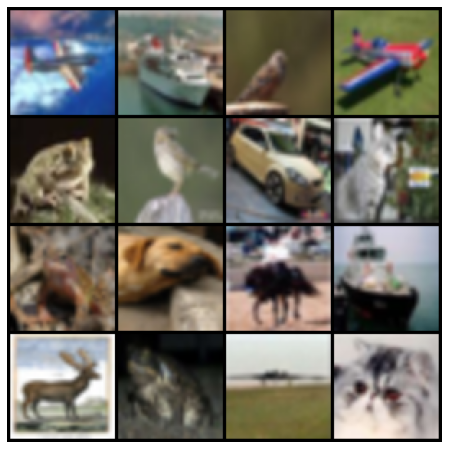

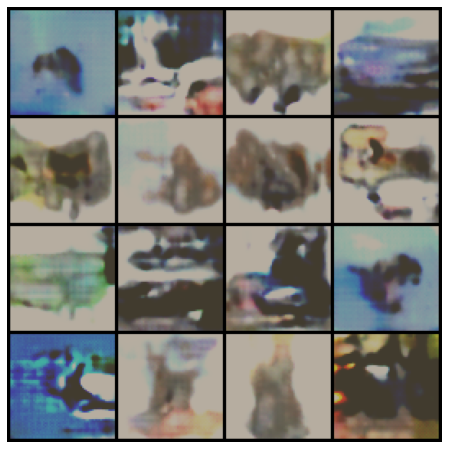

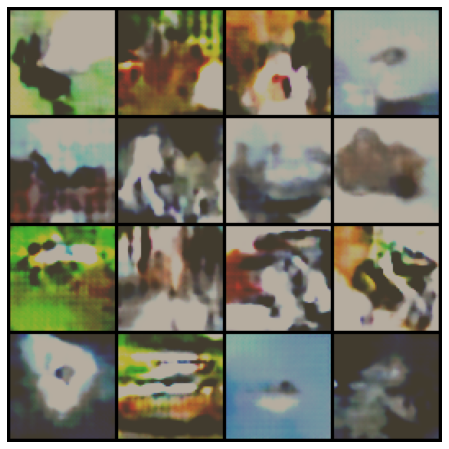

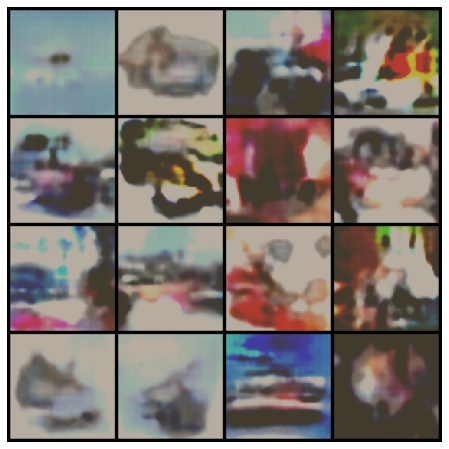

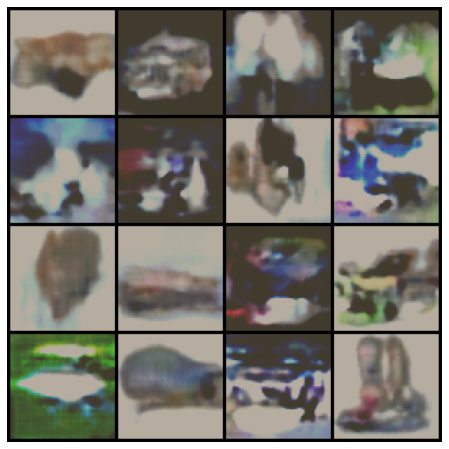

In [163]:
%matplotlib inline

def show_sample(x, num_samples=16, show_x=False):
    x = x.cuda(args.gpu)[:num_samples]
    if show_x:
        x_grid = vutils.make_grid(inv_normalize(x).cpu(), padding=2, nrow=4)
        plt.figure(figsize=(8,8))
        plt.axis("off")
        plt.imshow(x_grid.permute(1,2,0))

    model.eval()
    noise = torch.randn(num_samples, args.latent_dim).cuda(args.gpu)
    with torch.no_grad():
        repr = simsiam.encoder(x)
    z = torch.cat([repr, noise], dim=1)
    x_fake = model.G(z)
    im_grid = vutils.make_grid(inv_normalize(x_fake).cpu(), padding=2, nrow=4)
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.imshow(im_grid.permute(1,2,0))

x, _ = next(iter(train_loader))
show_sample(x, show_x=True)
show_sample(x)
show_sample(x)
show_sample(x)